In [5]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:41<00:00,  5.38s/it]


tensor([0.0000, 0.0706, 0.9922, 0.0353, 0.5294]) tensor([0.7883, 0.0064, 0.0689, 0.0013, 0.0013])
0.7882652878762257 [ -35.81681836  417.09029714 -986.38874158  606.40616145]


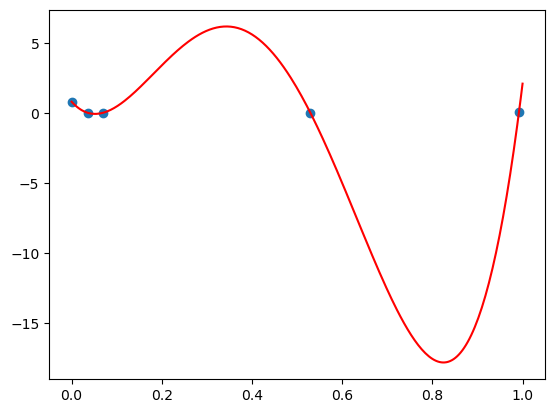

In [67]:
hb = torch.histogram(manager.training_data.data[0], bins=256)
hb_n = hb.hist / hb.hist.sum()

top_5 = torch.topk(hb_n, 3)
top_5_idx_sorted = top_5.indices.sort().values
mids = ((top_5_idx_sorted[:-1] + top_5_idx_sorted[1:]) / 2).to(int)
mids

x = torch.linspace(0, 1, 256)[torch.cat([top_5_idx_sorted, mids])]
y = hb_n[torch.cat([top_5_idx_sorted, mids])]
print(x, y)

plt.scatter(x, y)

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_features.fit_transform(x.view(-1, 1))

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_ , lin_reg.coef_)

test_x = torch.linspace(0, 1, 256)
pred_y = lin_reg.predict(poly_features.transform(test_x.view(-1, 1)))
plt.plot(test_x, pred_y, color='r')

In [69]:
hb = torch.histogram(manager.training_data.data[0], bins=256)
hb_n = hb.hist / hb.hist.sum()

top_5 = torch.topk(hb_n, 3)
top_5_idx_sorted = top_5.indices.sort().values
mids = ((top_5_idx_sorted[:-1] + top_5_idx_sorted[1:]) / 2).to(int)
mids

indices = torch.cat([top_5_idx_sorted, mids])
indices

tensor([  0,  18, 253,   9, 135])

In [6]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = (pred - x).abs().sum() / len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('abs 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


In [7]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:47<00:00,  5.60s/it]


In [10]:
def compare_with_vanilla(manager, name, original_name='vanilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

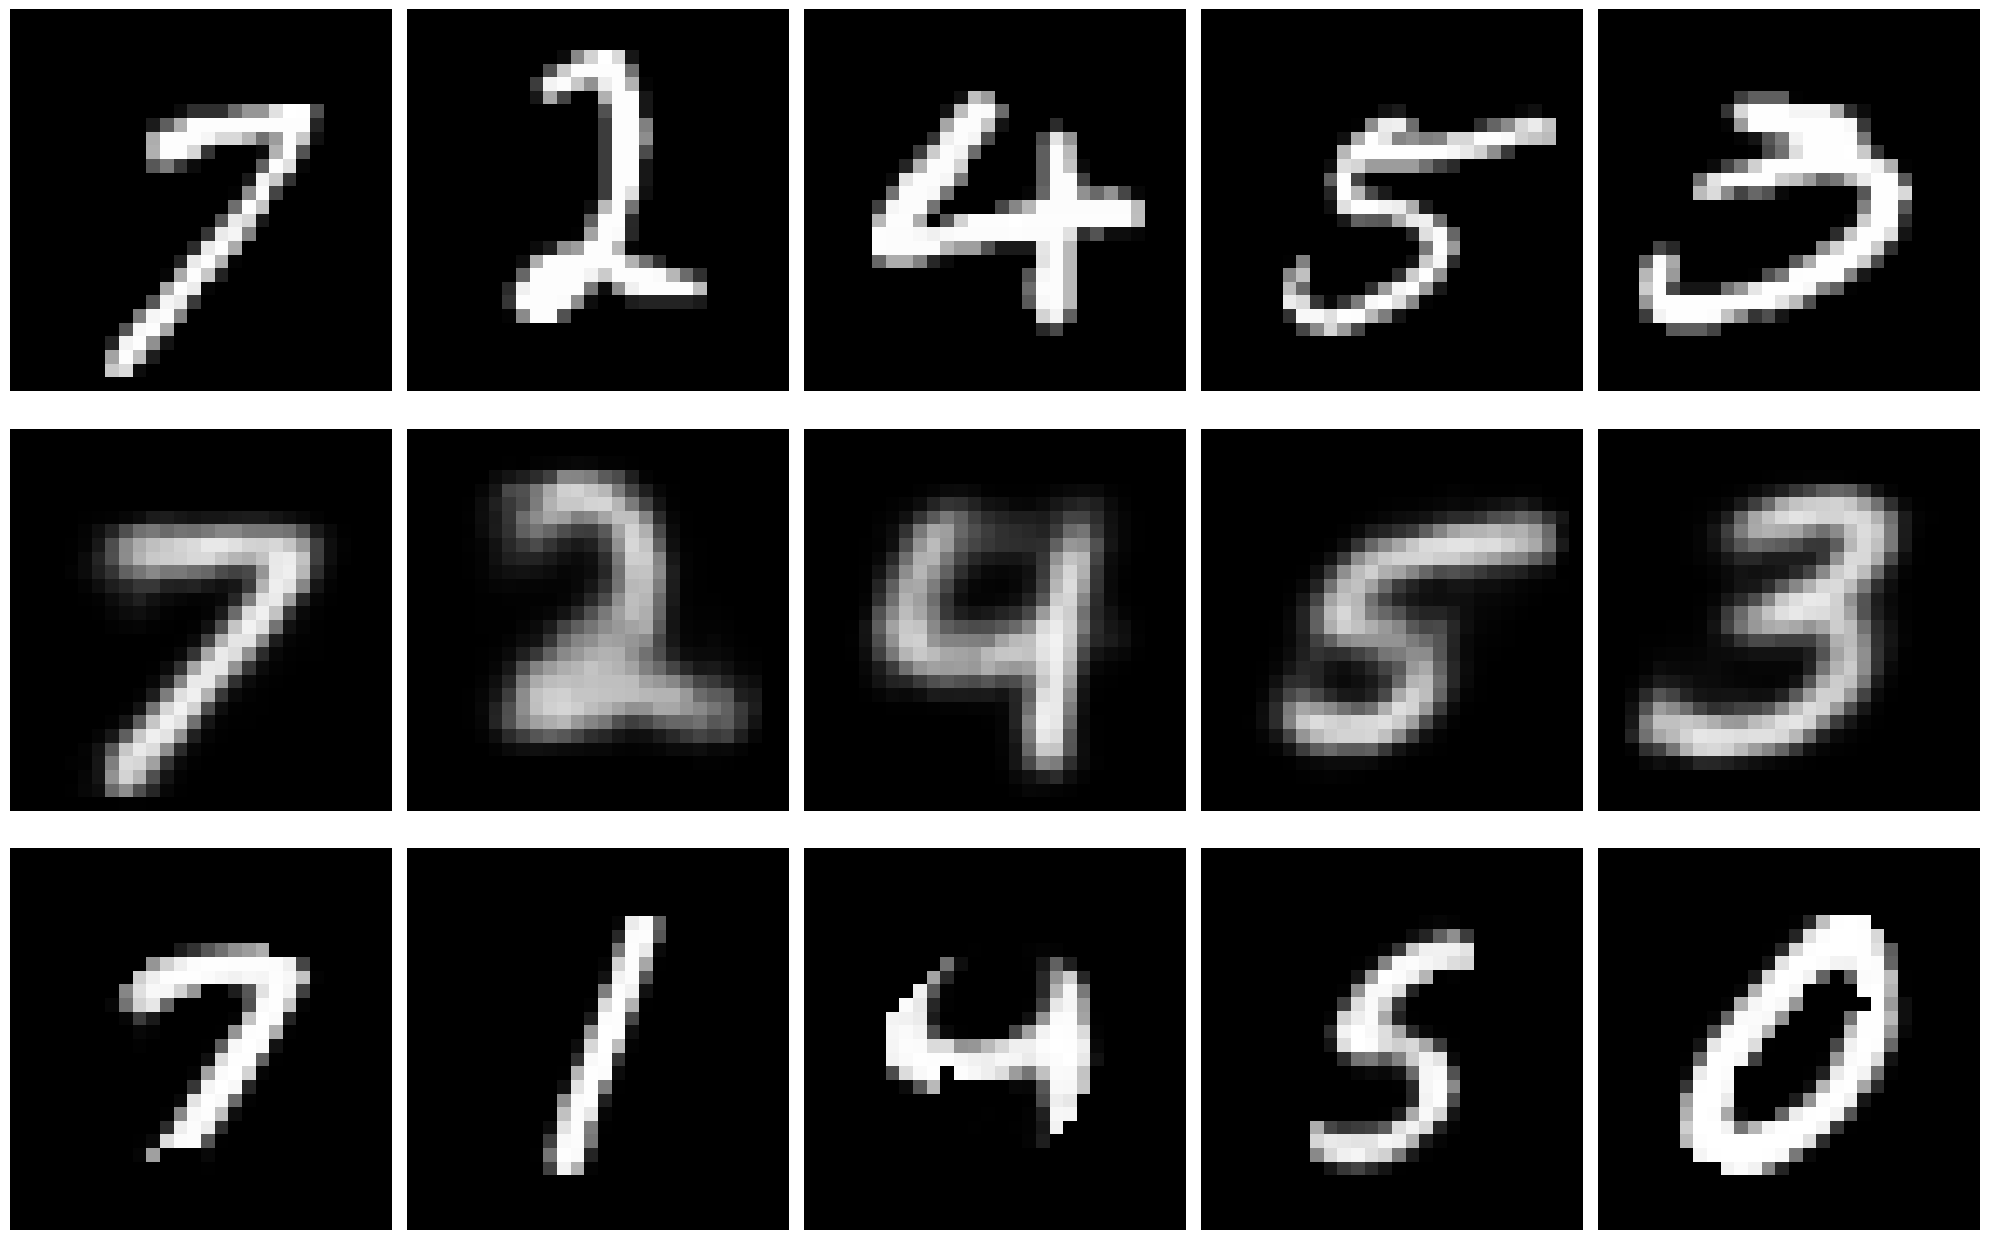

In [19]:
name = 'abs 30'
compare_with_vanilla(manager, name)

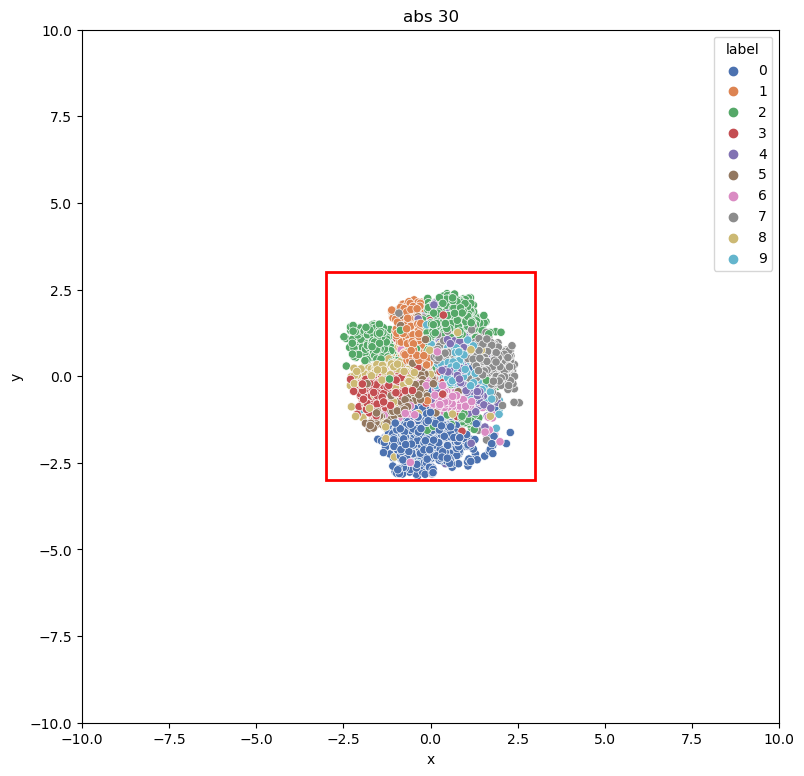

In [14]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space('abs 30', encode)

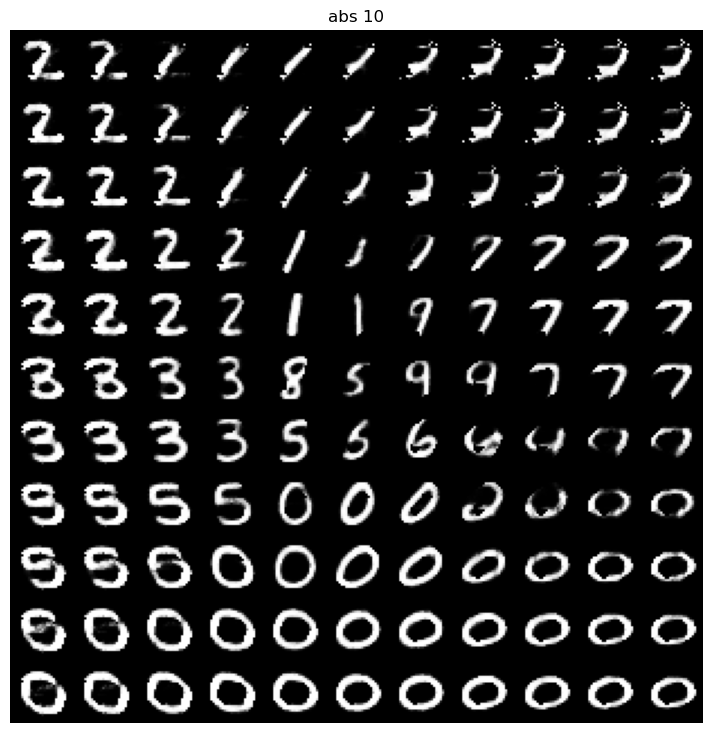

In [15]:
manager.plot_generated_images('abs 10')

In [31]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = (F.binary_cross_entropy(pred, x, reduction='sum') + (pred - x).abs().sum()) / len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('mse+abs 30')

Now, it is working on cuda:0.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:52<00:00,  5.75s/it]


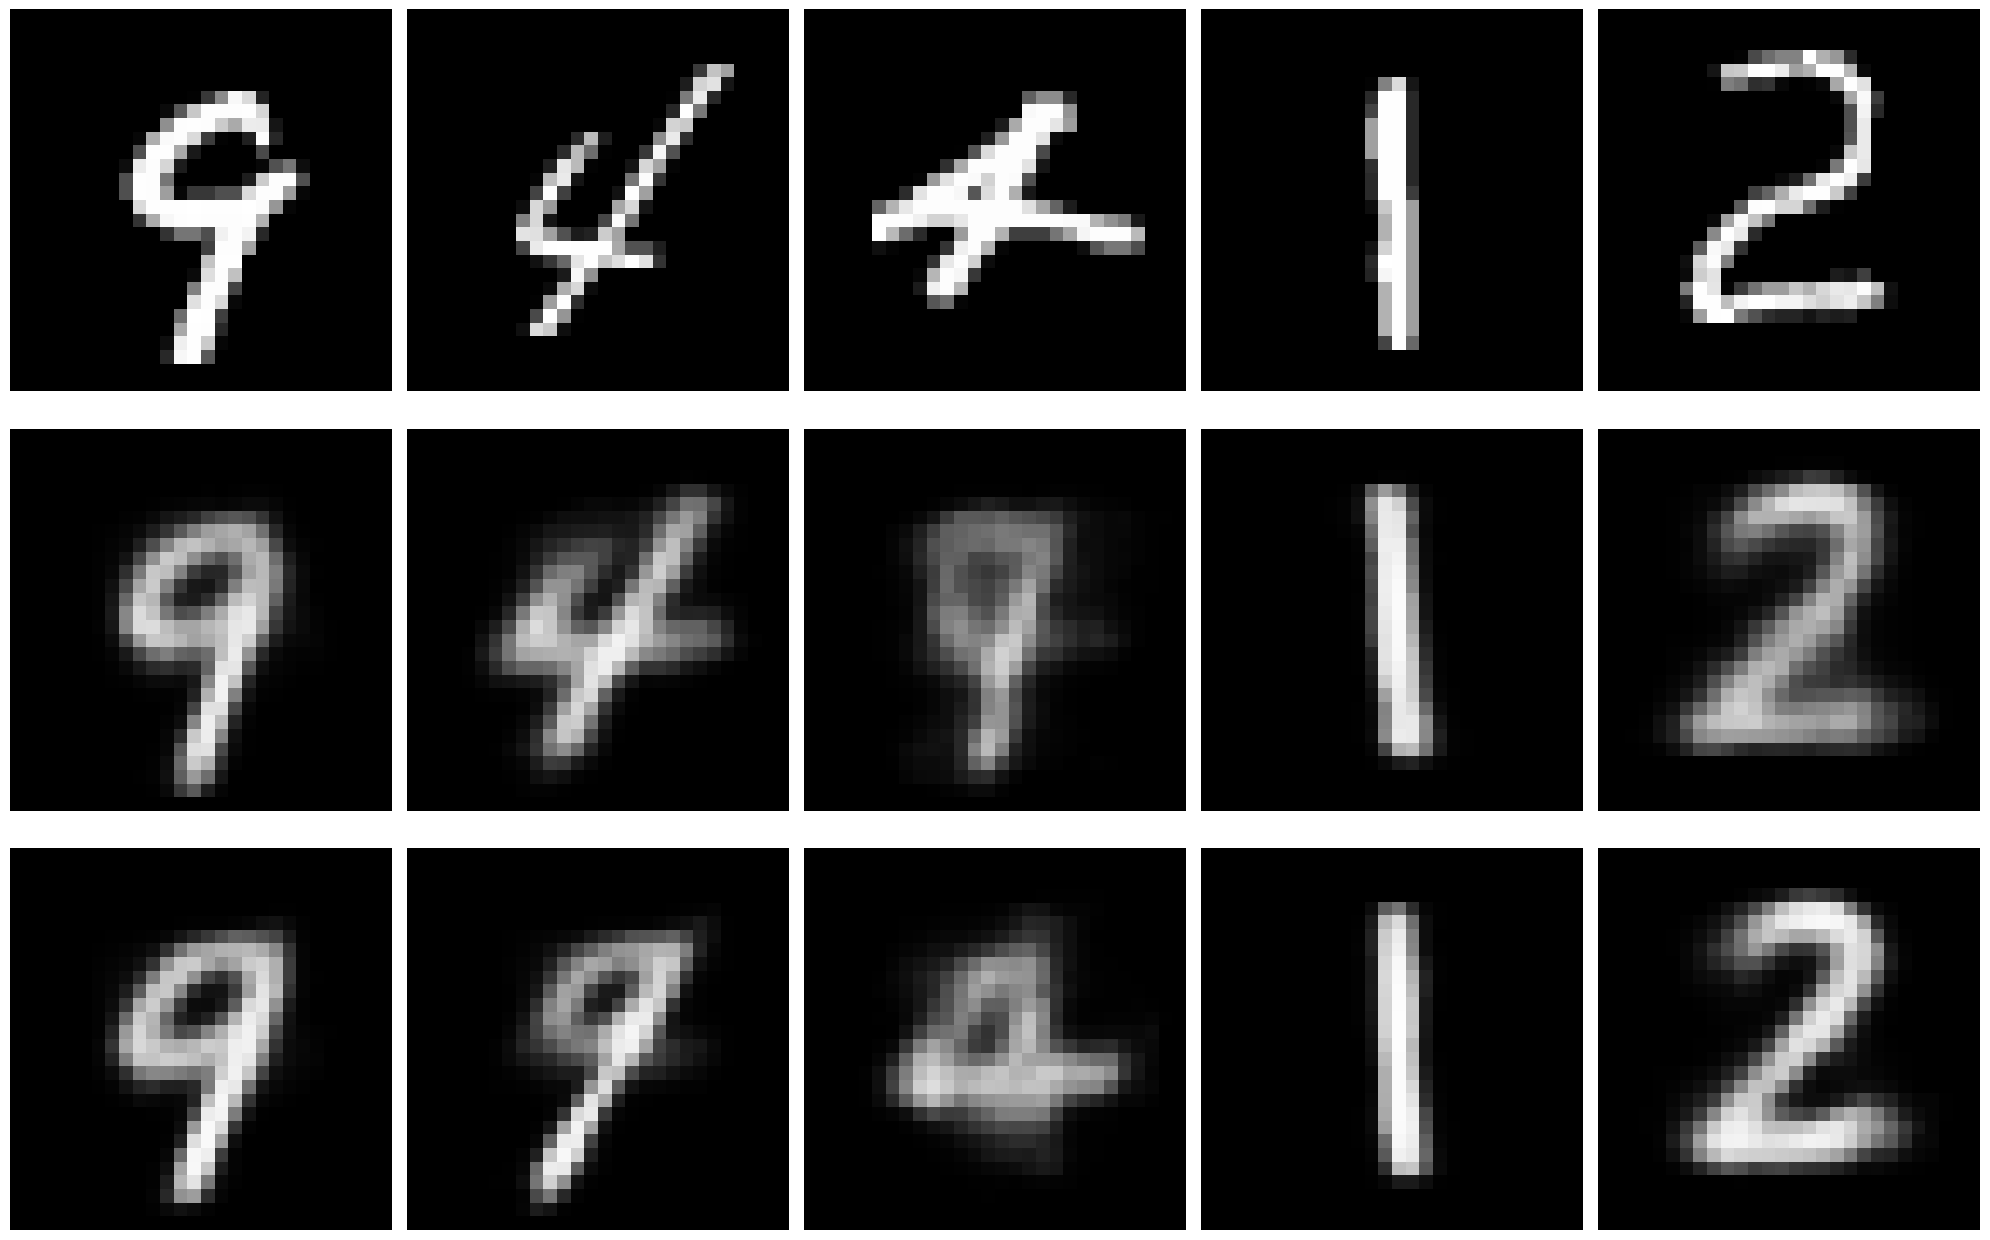

In [36]:
name = 'mse+abs 30'
compare_with_vanilla(manager, name)

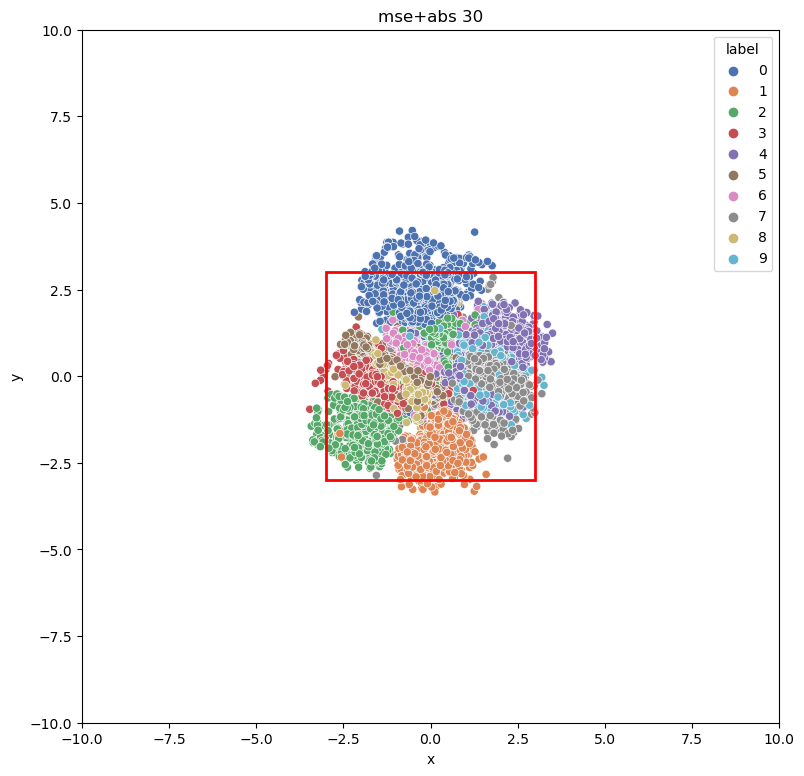

In [37]:
manager.show_latent_space('mse+abs 30', encode)

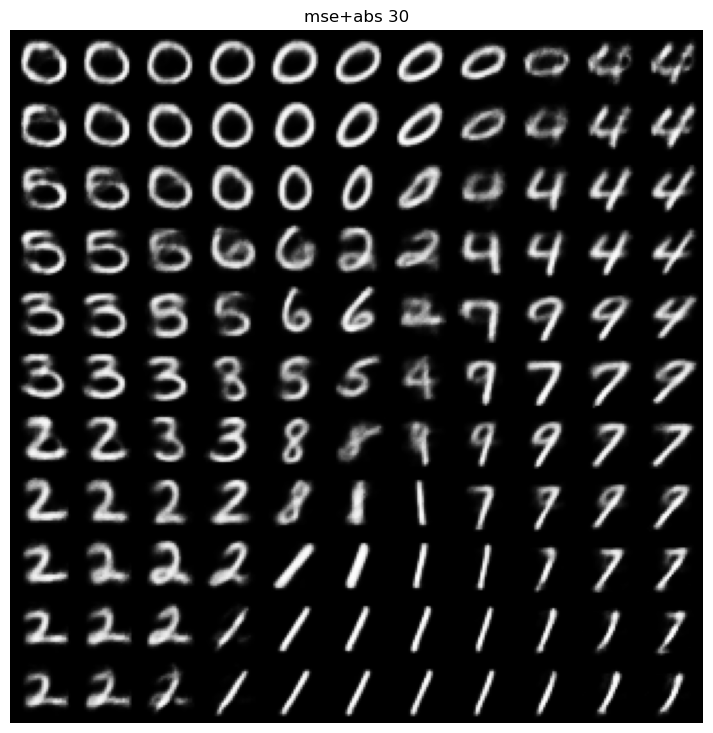

In [38]:
manager.plot_generated_images('mse+abs 30')

In [27]:
x = manager.training_data.data
a = lambda x: x.mean() * (x.mean() * (1 - x.mean()) / x.var() - 1)
b = lambda x: (1 - x.mean()) * (x.mean() * (1 - x.mean()) / x.var() - 1)

d = torch.distributions.Beta(a(x), b(x))

tmp_x_t = torch.linspace(0.05, 0.95, 300)
tmp_y_t = d.log_prob(tmp_x_t).exp()

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(tmp_x_t.view(-1, 1))

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, tmp_y_t)
print(lin_reg.intercept_ , lin_reg.coef_)

1.0826601216409715 [-2.19724949e+01  2.44611820e+02 -1.63687902e+03  6.99945503e+03
 -1.97381062e+04  3.70857347e+04 -4.59043468e+04  3.59217960e+04
 -1.60981544e+04  3.14744858e+03]


Now, it is working on cuda:0.


100%|██████████| 30/30 [03:48<00:00,  7.61s/it]


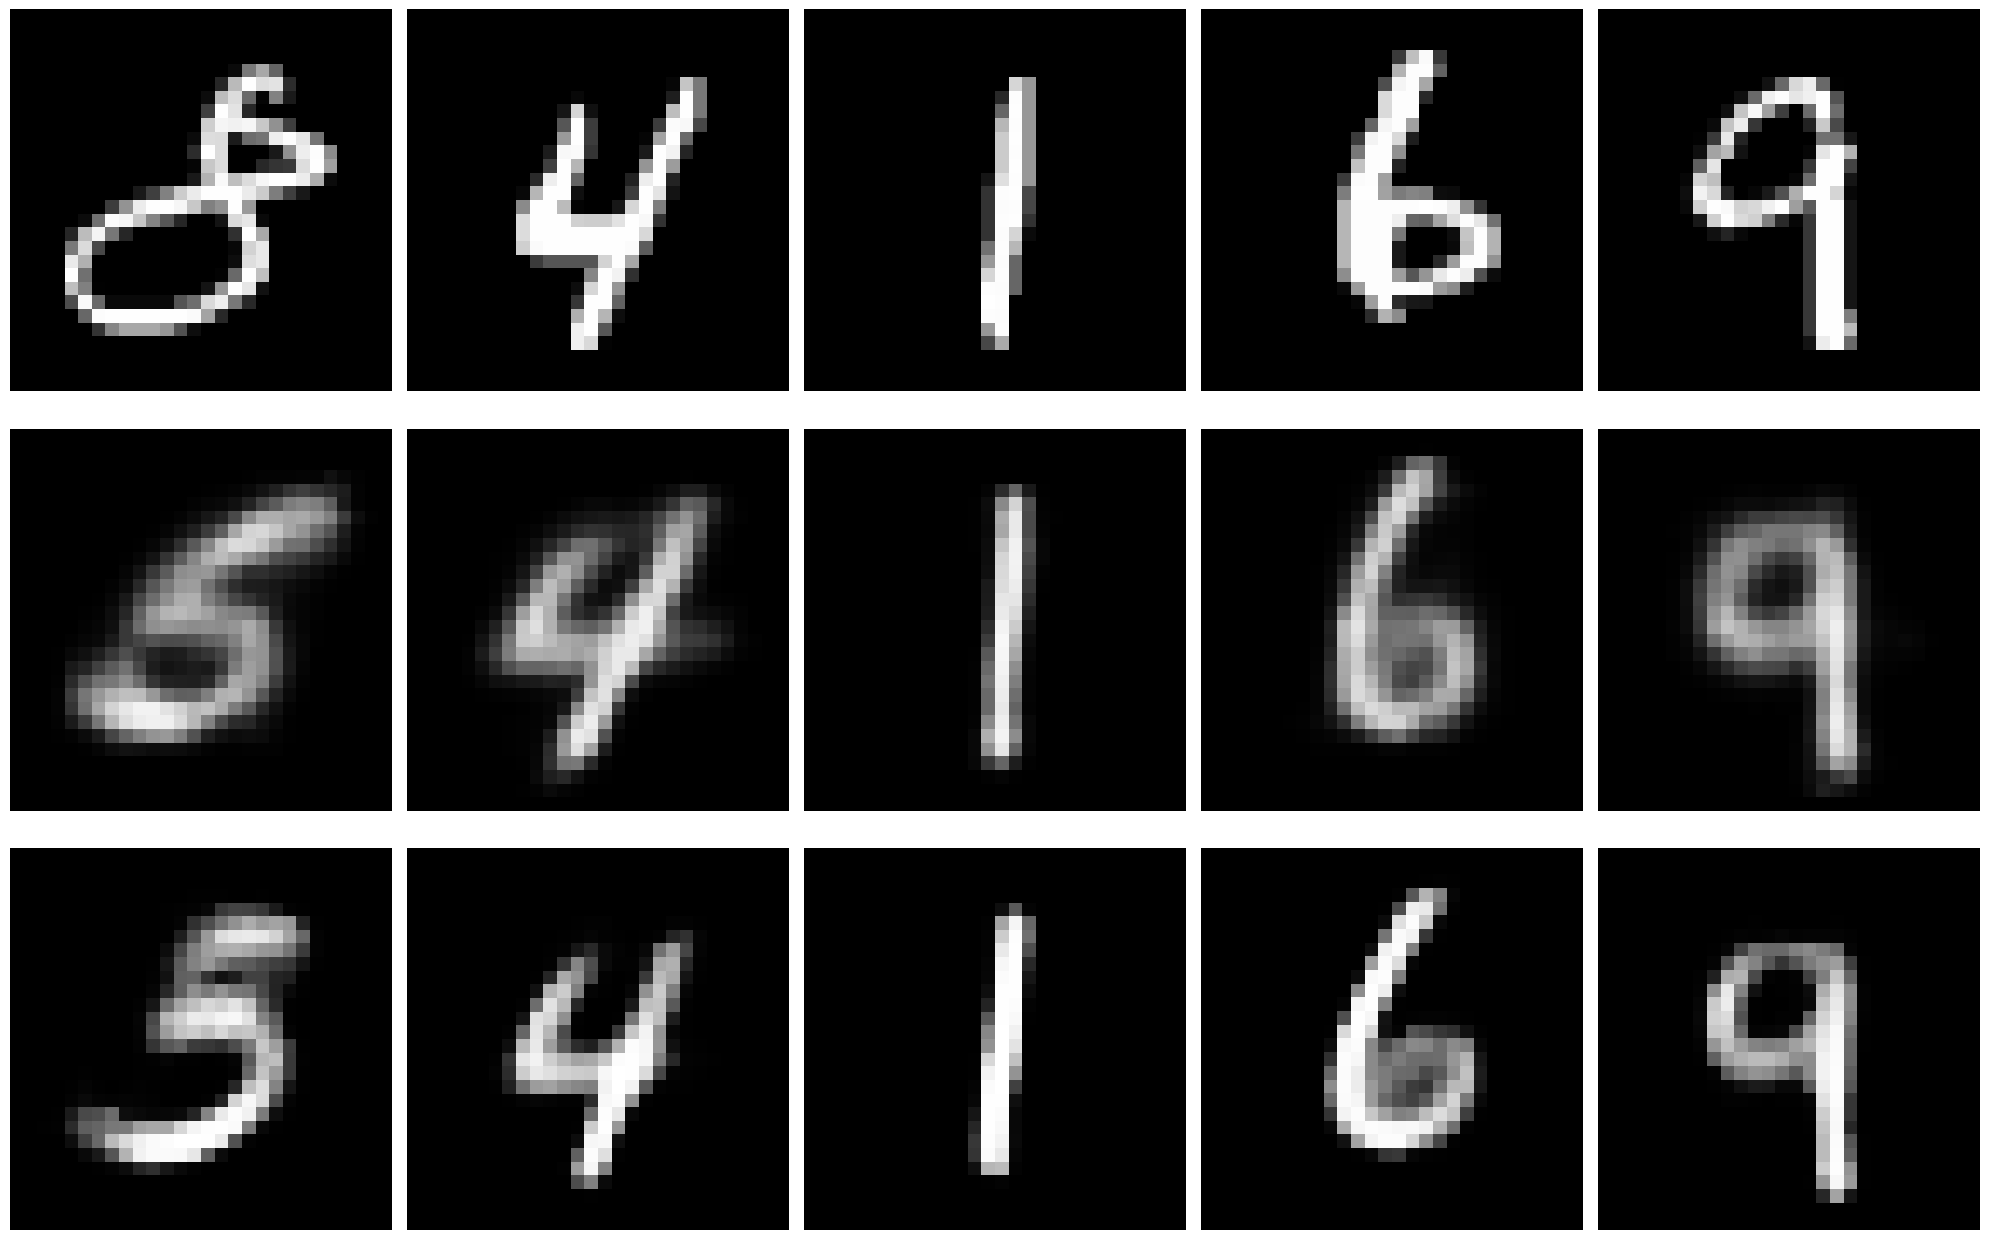

In [28]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    pe = torch.zeros_like(pred)
    p = 1
    for c in lin_reg.coef_:
        pe += c * pred**p
        p += 1
    pe += lin_reg.intercept_
    pe = (1.09 - pe).sum() / len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'pe 30'
manager.add_model(name)
compare_with_vanilla(manager, name)

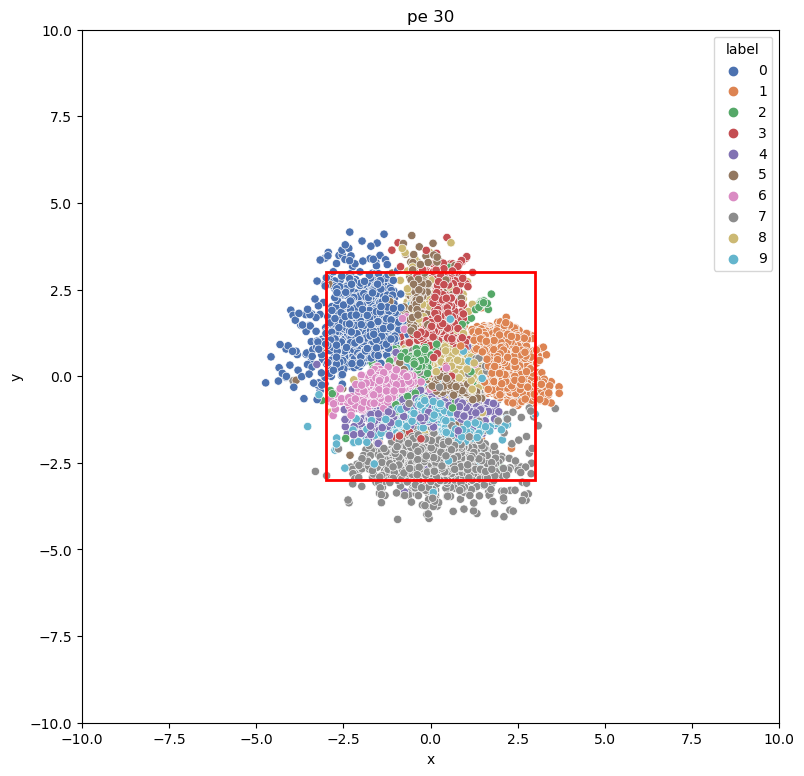

In [29]:
manager.show_latent_space('pe 30', encode)

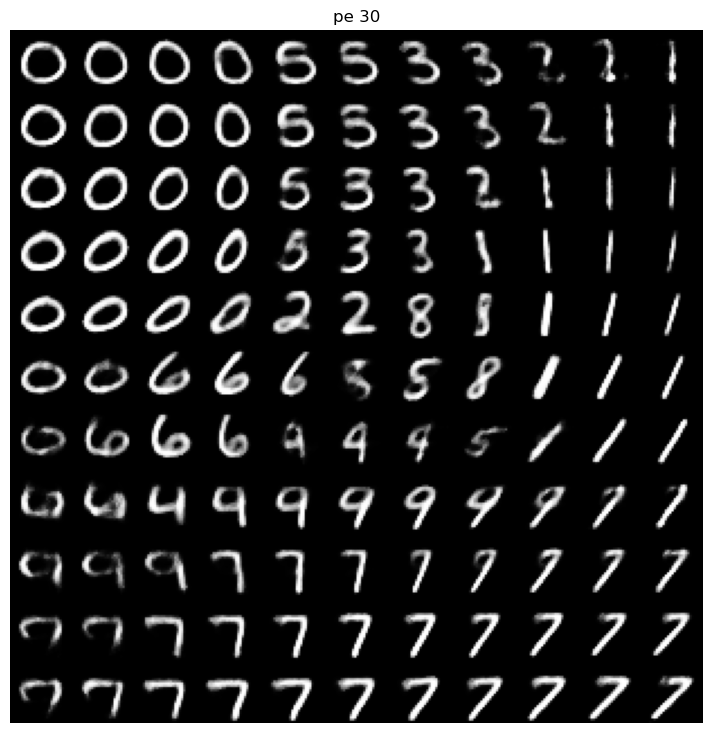

In [30]:
manager.plot_generated_images('pe 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [04:15<00:00,  8.51s/it]


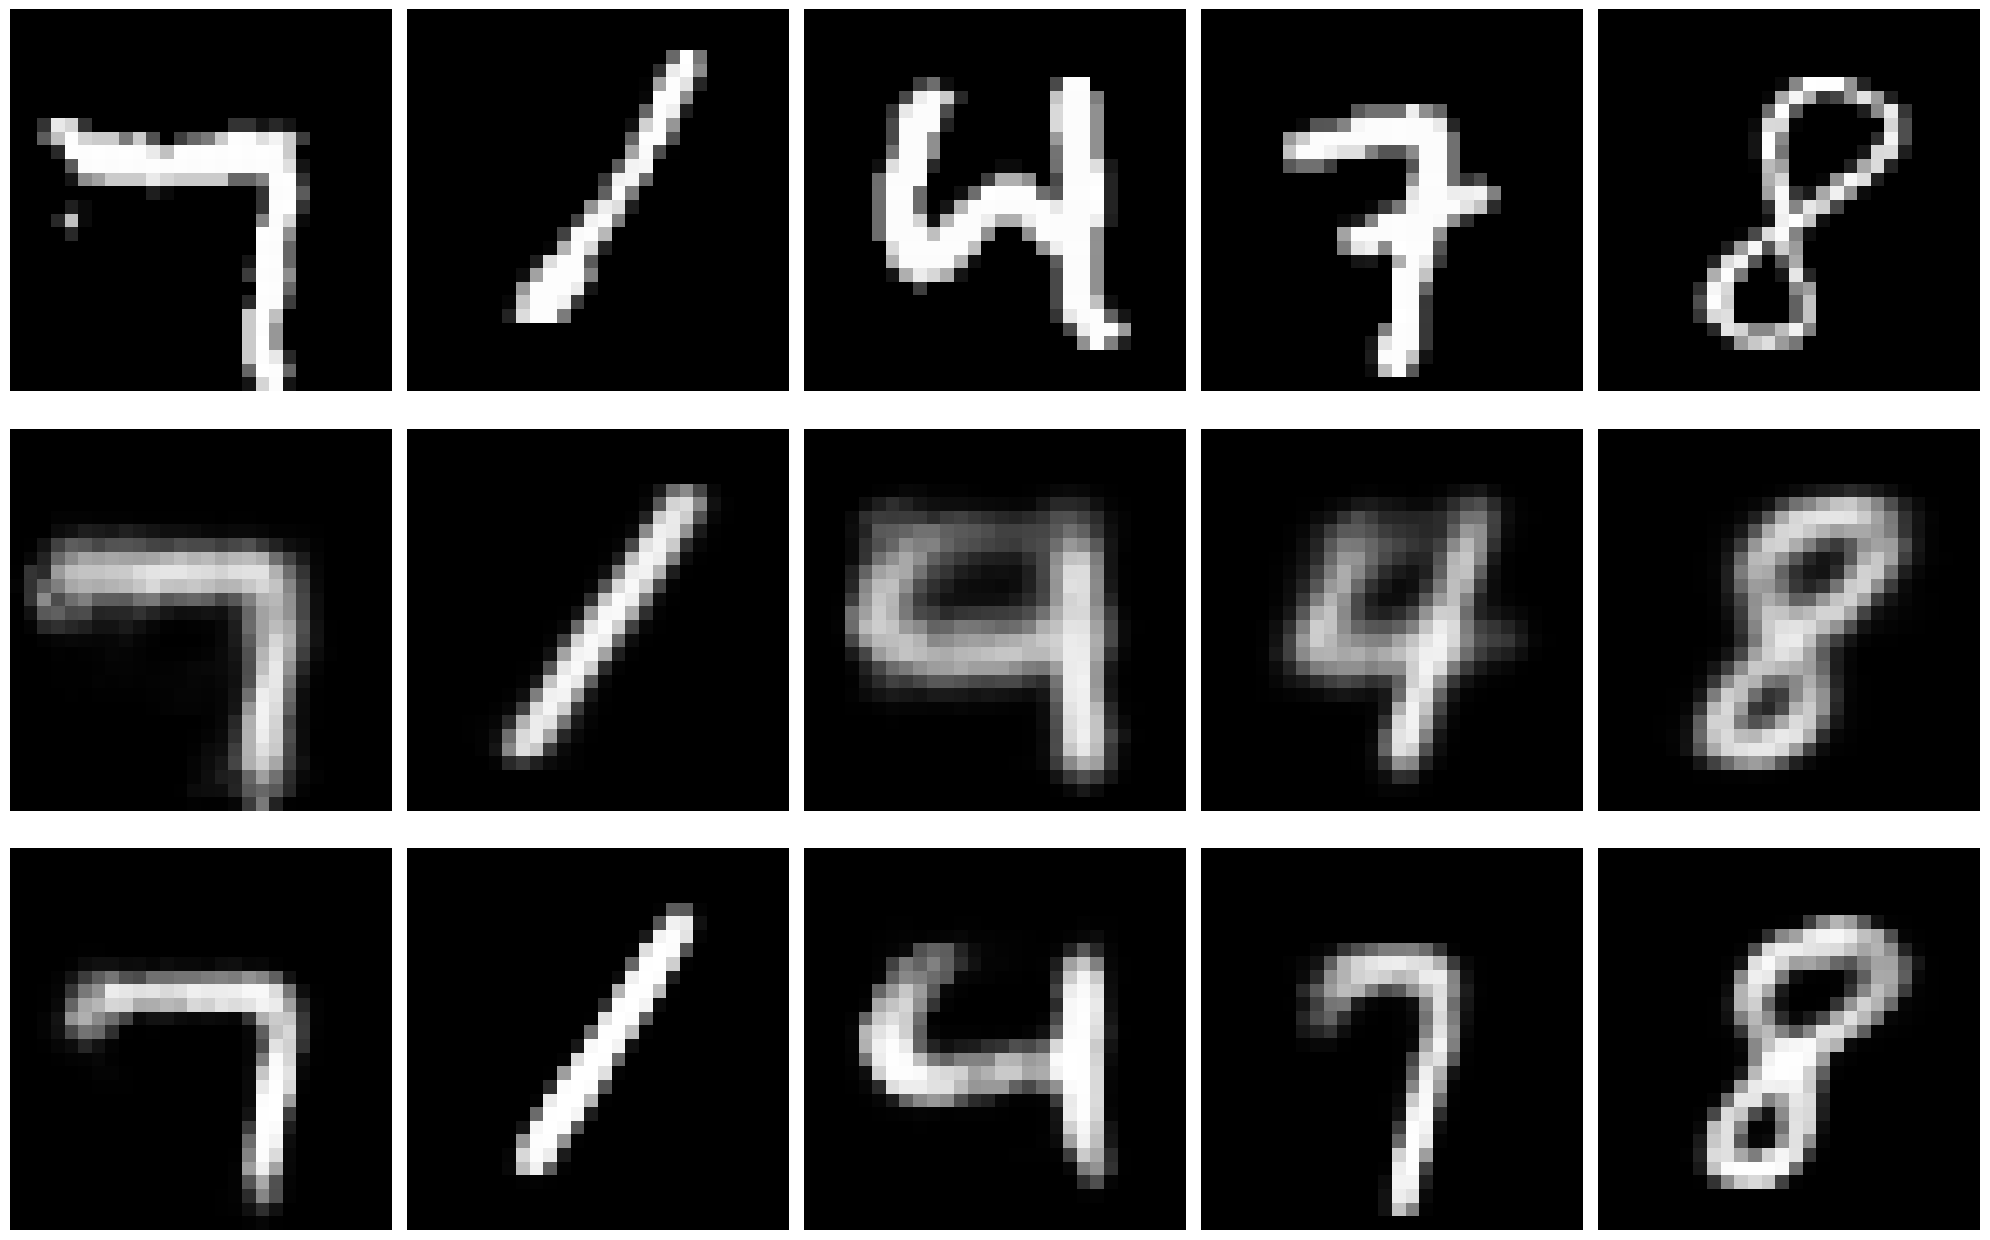

In [39]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    pe = torch.zeros_like(pred)
    p = 1
    for c in lin_reg.coef_:
        pe += c * pred**p
        p += 1
    pe += lin_reg.intercept_
    pe = (1.09 - pe).sum() / len(x)
    loss = ll + 2 * kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'pe kl*2 30'
manager.add_model(name)
compare_with_vanilla(manager, name)

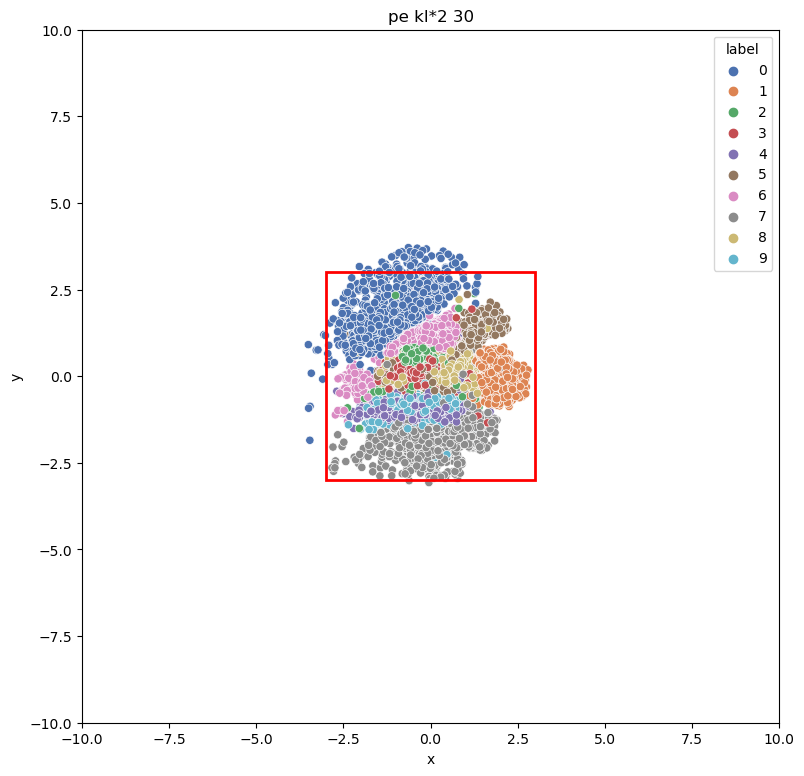

In [40]:
manager.show_latent_space('pe kl*2 30', encode)

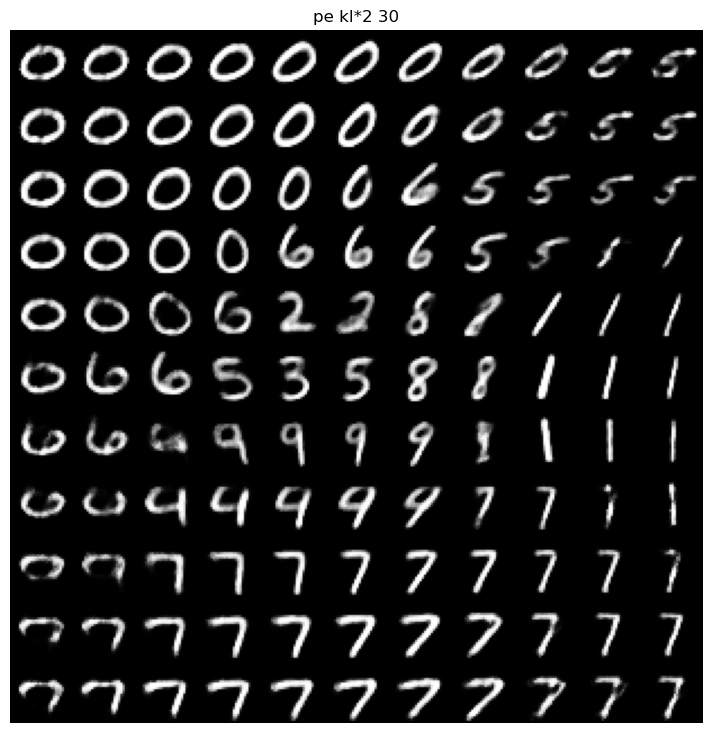

In [41]:
manager.plot_generated_images('pe kl*2 30')

In [42]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:48<00:00,  5.61s/it]


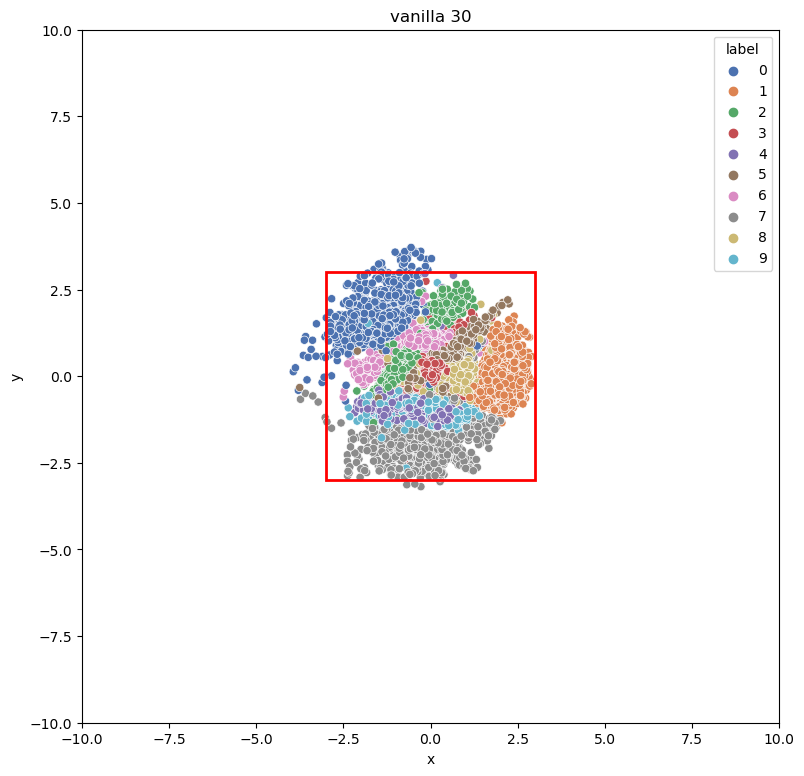

In [43]:
manager.show_latent_space('vanilla 30', encode)

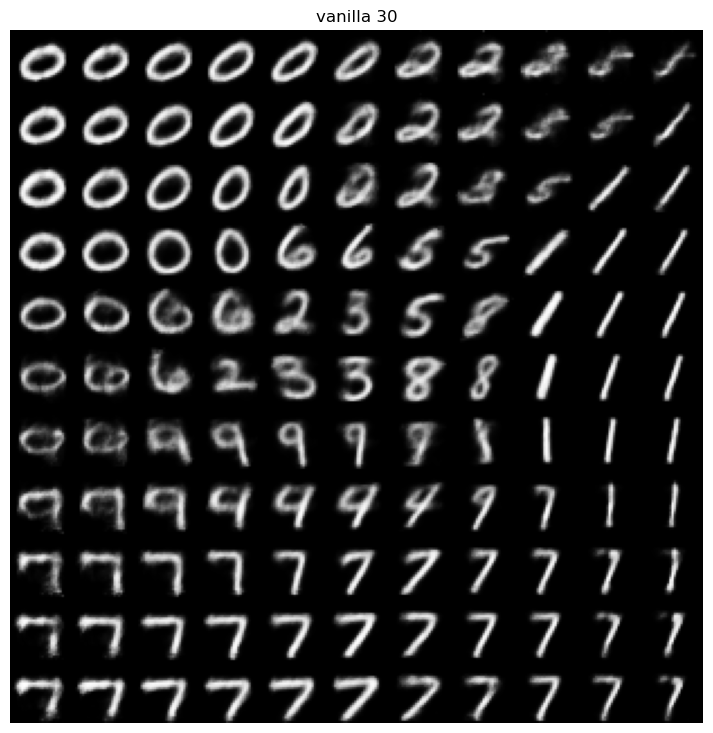

In [44]:
manager.plot_generated_images('vanilla 30')

In [49]:
with torch.no_grad():
    for x, y in manager.train_dataloader:
        h = manager.model.get_submodule("encoder")(x)
        z = h[:, :2]
        pred = manager.model.get_submodule("decoder")(z)
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        print(ll)

        manager.swap_current_model('pe 30')
        h = manager.model.get_submodule("encoder")(x)
        z = h[:, :2]
        pred = manager.model.get_submodule("decoder")(z)
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        print(ll)
        break

tensor(129.6528)
tensor(161.4072)
